In [1]:
import os

import numpy as np
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
import xarray as xr
import yaml

from src import data_catalog
from src.config import noaa_co2_flask_surface_dir, expr_metadata_fname, var_specs_fname
from src.esmlab_wrap import compute_ann_mean
from src.utils import time_year_plus_frac, print_timestamp
from src.latlon_sel_mod import latlon_sel_get_var
from src.utils_noaa_co2_flask_surface import co2_flask_surface_read_file
from src.utils_plot import gen_plot_opt_list, fig_fname_resolved
from src.utils_units import conv_units

%matplotlib inline

In [2]:
def dataset_summary(ds_list, legend_list, color_list, linestyle_list):
    fig_dict = {}
    ax_dict = {}
    fig_dict["mon_values"], ax_dict["mon_values"] = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 4))
    fig_dict["ann_values"], ax_dict["ann_values"] = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 4))
    fig_dict["mon_anomalies"], ax_dict["mon_anomalies"] = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 4))
    fig_dict["seas_cyc"], ax_dict["seas_cyc"] = plt.subplots(nrows=2, ncols=1, figsize=(7.5,6))
    for ind, ds in enumerate(ds_list):
        time = time_year_plus_frac(ds, "time")
        print(f"samples = {len(time)}")
        year_min = np.floor(time.min())
        year_max = np.ceil(time.max())
        print(f"year_span = {year_min}-{year_max}" )
        print(f"samples per year = {len(time) / (year_max - year_min)}" )
        print("****************************************")

        label = legend_list[ind]

        ds["CO2"].plot(ax=ax_dict["mon_values"], label=label, linewidth=2.0,
                       color=color_list[ind], linestyle=linestyle_list[ind])

        ds_ann = compute_ann_mean(ds).load()
        ds_ann["CO2"].plot(ax=ax_dict["ann_values"], label=label, linewidth=2.0,
                           color=color_list[ind], linestyle=linestyle_list[ind])

        ds_trunc = ds.isel(time=slice(12,-12))
        ds_mon_anom = ds_trunc - ds_ann.interp(time=ds_trunc.time)
        ds_mon_anom["CO2"].plot(ax=ax_dict["mon_anomalies"], label=label, linewidth=2.0,
                                color=color_list[ind], linestyle=linestyle_list[ind])

        ds_mon_anom_slice = ds_mon_anom.sel(time=slice("1981-01-01", "2005-01-01"))
        ds_mon_anom_clim = ds_mon_anom_slice.groupby("time.month").mean("time", keep_attrs=True)
        ds_mon_anom_clim["CO2"].plot(ax=ax_dict["seas_cyc"][0], label=label, linewidth=2.0,
                                     color=color_list[ind], linestyle=linestyle_list[ind])

        ds_year_max = ds_mon_anom.groupby("time.year").max("time", keep_attrs=True)
        ds_year_min = ds_mon_anom.groupby("time.year").min("time", keep_attrs=True)
        ds_seas_amp = ds_year_max - ds_year_min
        ds_seas_amp["CO2"].plot(ax=ax_dict["seas_cyc"][1], label=label, linewidth=2.0,
                                color=color_list[ind], linestyle=linestyle_list[ind])

    for ax in ax_dict.values():
        if isinstance(ax, np.ndarray):
            for ax_ind, ax_single in enumerate(ax):
                if ax_ind == 0:
                    ax_single.legend(handlelength=6)
                ax_single.set_title(None)
        else:
            ax.legend(handlelength=6)
            ax.set_title(None)

    plt.show()

    return fig_dict

{'brw': {'year_span': (1972, 2019), 'lat': 71.32, 'lon': 203.4, 'press': 1000.0}, 'mlo': {'year_span': (1977, 2019), 'lat': 19.53, 'lon': 204.32, 'press': 680.0}}
slice('1972-01-01', '2019-01-01', None)
samples = 564
year_span = 1972.0-2019.0
samples per year = 12.0
****************************************


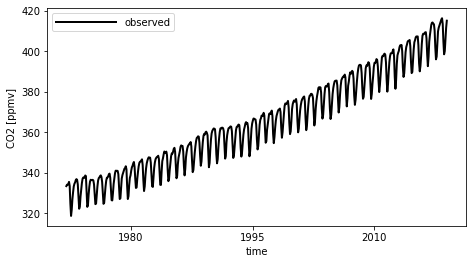

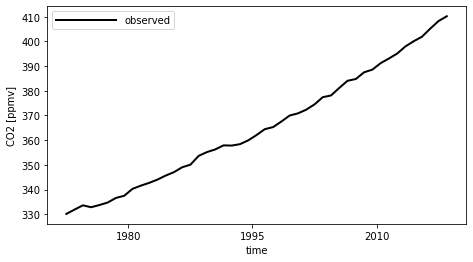

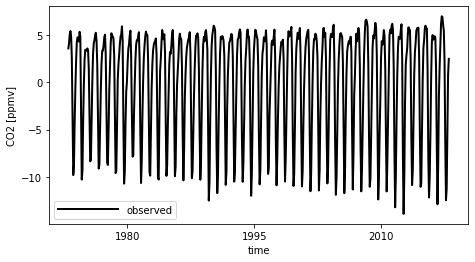

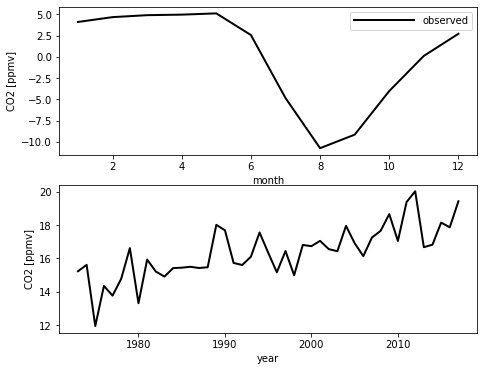

slice('1977-01-01', '2019-01-01', None)
samples = 504
year_span = 1977.0-2019.0
samples per year = 12.0
****************************************


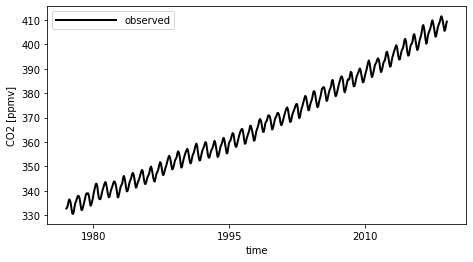

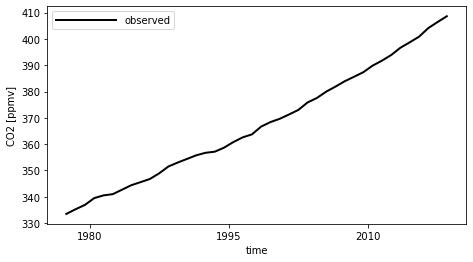

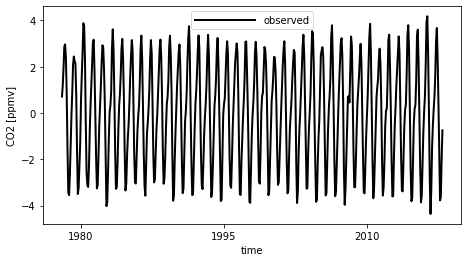

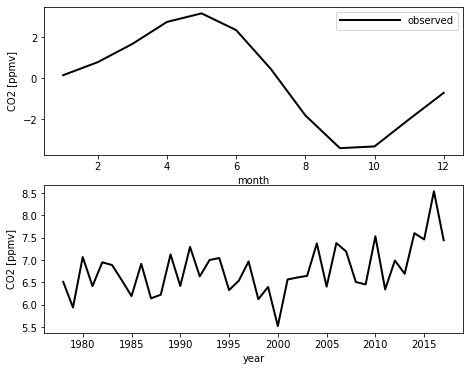

In [3]:
site_metadata_dict = {
    "brw": {"year_span": (1972, 2019), "lat": 71.32, "lon": (360-156.60), "press": 1000.0},
    "mlo": {"year_span": (1977, 2019), "lat": 19.53, "lon": (360-155.68), "press": 680.0},
}
print(site_metadata_dict)

ds_obs = {}
for site, site_metadata in site_metadata_dict.items():
    path = os.path.join(noaa_co2_flask_surface_dir, "surface", f"co2_{site}_surface-flask_1_ccgg_month.txt")
    year_span = site_metadata["year_span"]
    time_sel = slice(f"{year_span[0]:04d}-01-01", f"{year_span[1]:04d}-01-01")
    print(time_sel)
    ds_obs[site] = co2_flask_surface_read_file(path)[["time_bounds", "CO2"]].sel(time=time_sel)
    for key in ["lat", "lon"]:
        ds_obs[site].attrs[key] = site_metadata[key]
    dataset_summary([ds_obs[site]], color_list=["k"], legend_list=["observed"], linestyle_list=["solid"])

In [4]:
collection_name = "cesm_coupled"
data_catalog.set_catalog(collection_name)

with open(expr_metadata_fname) as fptr:
    expr_metadata_all = yaml.full_load(fptr)
expr_metadata = expr_metadata_all[collection_name]["data_sources"]

with open(var_specs_fname, mode="r") as fptr:
    var_specs_all = yaml.safe_load(fptr)

varname = "CO2"
component = "atm"

var_spec = var_specs_all[component]["vars"][varname]

active catalog: cesm_coupled


samples = 564
year_span = 1972.0-2019.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 1032
year_span = 1920.0-2006.0
samples per year = 12.0
****************************************


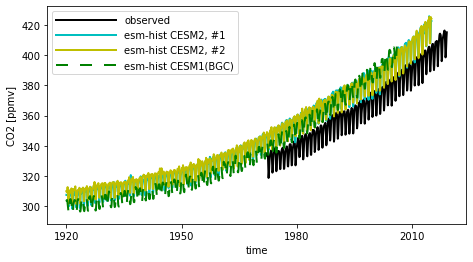

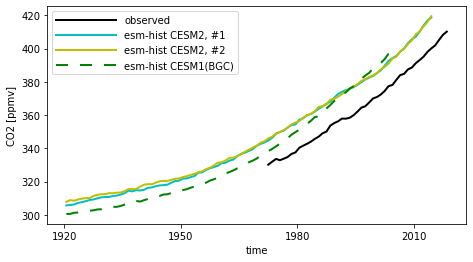

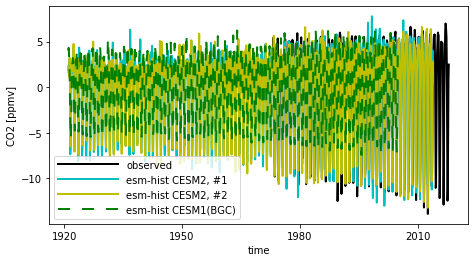

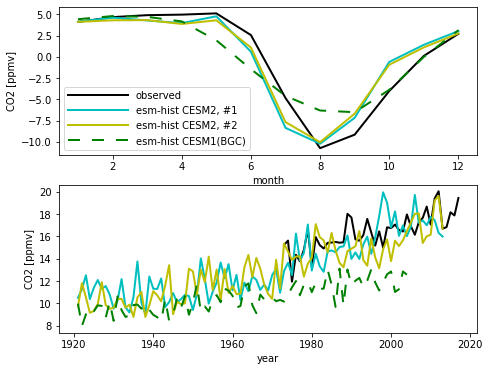

samples = 564
year_span = 1972.0-2019.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 1032
year_span = 1920.0-2006.0
samples per year = 12.0
****************************************


<Figure size 432x288 with 0 Axes>

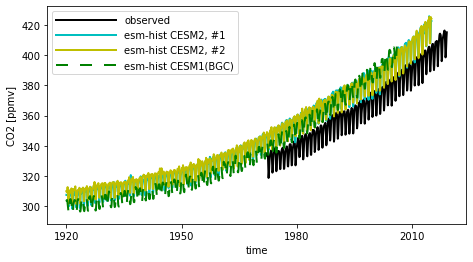

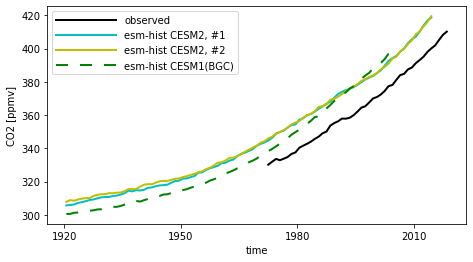

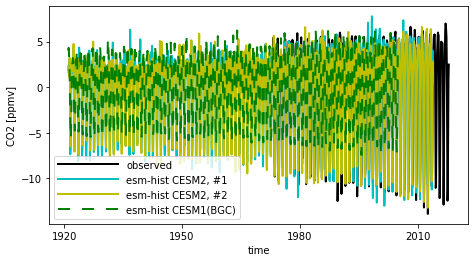

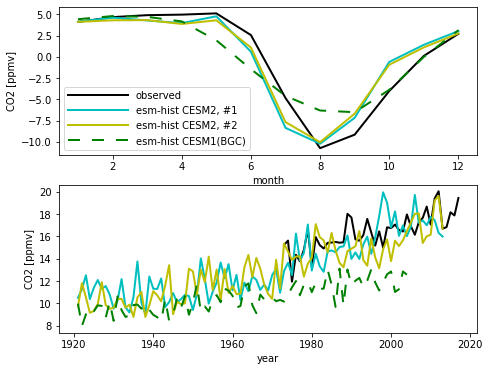

samples = 504
year_span = 1977.0-2019.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 1032
year_span = 1920.0-2006.0
samples per year = 12.0
****************************************


<Figure size 432x288 with 0 Axes>

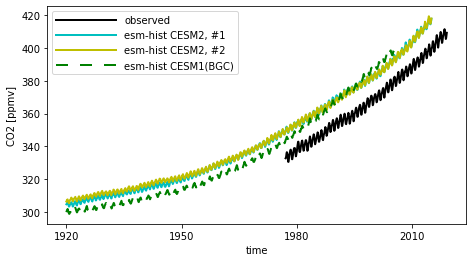

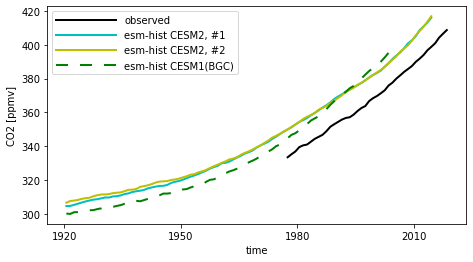

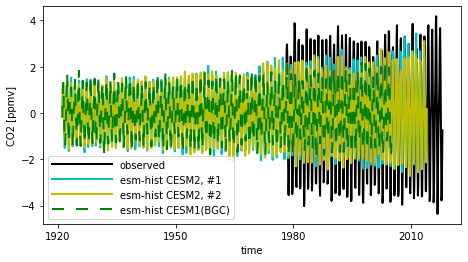

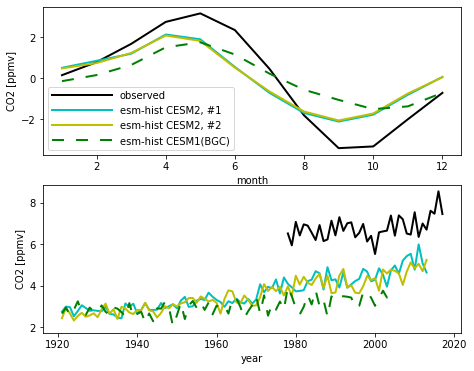

samples = 504
year_span = 1977.0-2019.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 1032
year_span = 1920.0-2006.0
samples per year = 12.0
****************************************


<Figure size 432x288 with 0 Axes>

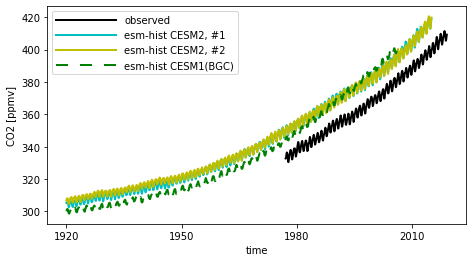

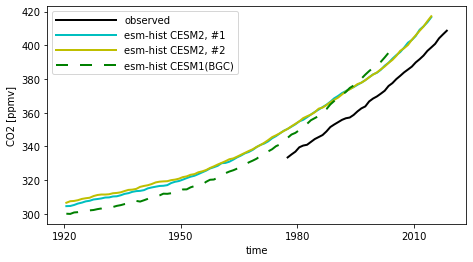

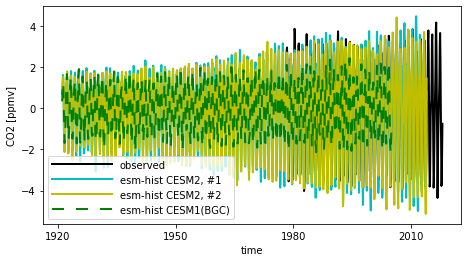

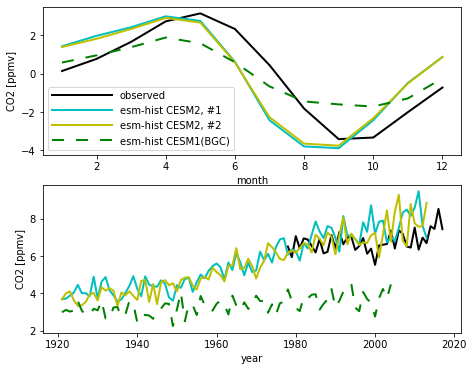

In [5]:
for site, site_metadata in site_metadata_dict.items():
    time_sel = slice("1920-01-01", "2015-01-01")
    lat = site_metadata["lat"]
    lon = site_metadata["lon"]

    ds_dict = {}

    experiment = "esm-hist"
    ds_dict[experiment] = latlon_sel_get_var(varname, lat, lon, component, experiment)
    ds_dict[experiment].attrs["legend"] = "esm-hist CESM2"

    experiment = "esm-hist-cmip5"
    ds_dict[experiment] = latlon_sel_get_var(varname, lat, lon, component, experiment, "cam2.h0")
    ds_dict[experiment].attrs["legend"] = "esm-hist CESM1(BGC)"

    for press in [site_metadata["press"], 1000.0]:
        seldict = {"lev": press}

        ds_list = [ds_obs[site]]
        legend_list = ["observed"]
        color_list = ["k"]
        linestyle_list = ["solid"]

        for expr, ds in ds_dict.items():
            ds_sel = ds.sel(seldict, method="nearest").sel(time=time_sel)
            if "unit_conv" in var_spec and "waccm" not in expr:
                ds_sel[varname].attrs["units"] = f"({var_spec['unit_conv']})({ds_sel[varname].attrs['units']})"
            if "display_units" in var_spec:
                ds_sel[varname] = conv_units(ds_sel[varname], var_spec["display_units"])
            if "ensemble" in ds_sel.dims:
                for ensemble in range(ds.sizes["ensemble"]):
                    ds_list.append(ds_sel.isel(ensemble=ensemble))
                    legend_list.append(f"{ds.attrs['legend']}, #{ensemble+1}")
                    color_list.append(expr_metadata[expr][ensemble]["plot_opts"]["color"])
                    linestyle_list.append(expr_metadata[expr][ensemble]["plot_opts"]["linestyle"])
            else:
                ds_list.append(ds_sel)
                legend_list.append(ds.attrs["legend"])
                color_list.append(expr_metadata[expr][0]["plot_opts"]["color"])
                linestyle_list.append(expr_metadata[expr][0]["plot_opts"]["linestyle"])
        fig_dict = dataset_summary(ds_list, legend_list, color_list, linestyle_list)

        if press == site_metadata["press"]:
            plt.figure(fig_dict["seas_cyc"].number)
            fname = f"CO2_seas_cyc_{site}.pdf"
            plt.savefig(fig_fname_resolved(fname), dpi=600, metadata={"CreationDate": None})

samples = 564
year_span = 1972.0-2019.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************


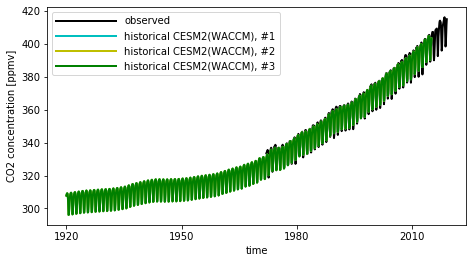

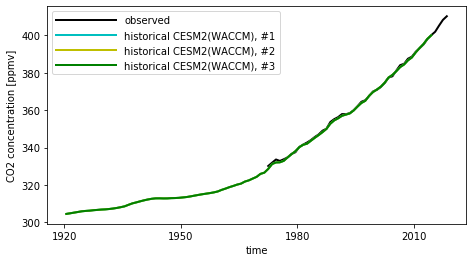

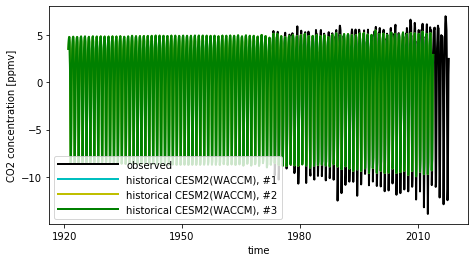

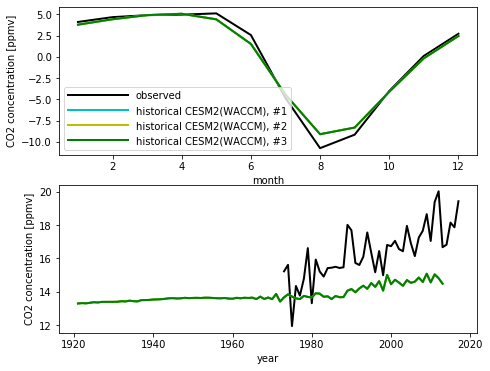

samples = 504
year_span = 1977.0-2019.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************


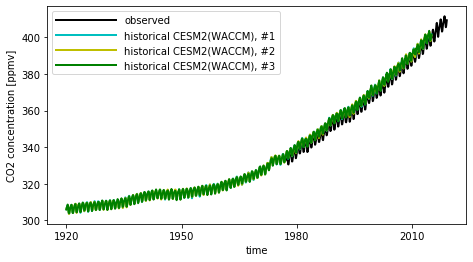

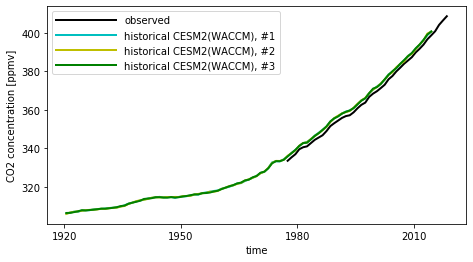

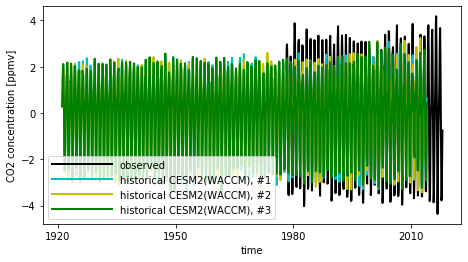

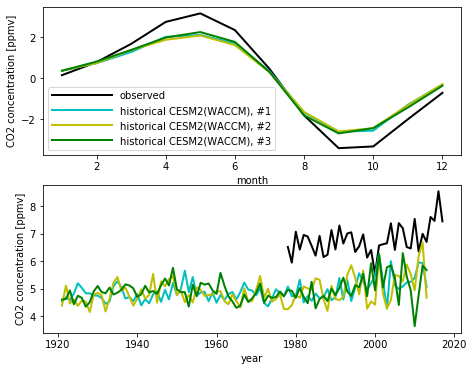

In [6]:
for site, site_metadata in site_metadata_dict.items():
    time_sel = slice("1920-01-01", "2015-01-01")
    lat = site_metadata["lat"]
    lon = site_metadata["lon"]

    ds_dict = {}

    experiment = "historical-waccm"
    ds_dict[experiment] = latlon_sel_get_var(varname, lat, lon, component, experiment)
    ds_dict[experiment].attrs["legend"] = "historical CESM2(WACCM)"

    seldict = {"lev": site_metadata["press"]}

    ds_list = [ds_obs[site]]
    legend_list = ["observed"]
    color_list = ["k"]
    linestyle_list = ["solid"]

    for expr, ds in ds_dict.items():
        ds_sel = ds.sel(seldict, method="nearest").sel(time=time_sel)
        if "unit_conv" in var_spec and "waccm" not in expr:
            ds_sel[varname].attrs["units"] = f"({var_spec['unit_conv']})({ds_sel[varname].attrs['units']})"
        if "display_units" in var_spec:
            ds_sel[varname] = conv_units(ds_sel[varname], var_spec["display_units"])
        if "ensemble" in ds_sel.dims:
            for ensemble in range(ds.sizes["ensemble"]):
                ds_list.append(ds_sel.isel(ensemble=ensemble))
                legend_list.append(f"{ds.attrs['legend']}, #{ensemble+1}")
                color_list.append(expr_metadata[expr][ensemble]["plot_opts"]["color"])
                linestyle_list.append(expr_metadata[expr][ensemble]["plot_opts"]["linestyle"])
        else:
            ds_list.append(ds_sel)
            legend_list.append(ds.attrs["legend"])
            color_list.append(expr_metadata[expr][0]["plot_opts"]["color"])
            linestyle_list.append(expr_metadata[expr][0]["plot_opts"]["linestyle"])
    fig_dict = dataset_summary(ds_list, legend_list, color_list, linestyle_list)